Mamy za zadanie stworzyć jak najlepszy model do rozróżniania zakażenia malarią ze zdjęć komórkowych. Nasz zbiór zawiera 27549 zdjęć komórkowych.

Importujemy potrzebne biblioteki

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Rescaling

Ustalamy jeden rozmiar obrazów

In [2]:
batch_size = 80
img_height = 128
img_width = 128

Dzielimy zbiór danych na treningowy, walidacyjny i testowy

In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  'cell_images/cell_images',
  validation_split=0.2,
  subset="validation",
  seed=12,
  image_size=(img_height, img_width),
  batch_size=batch_size)

train_ds = tf.keras.utils.image_dataset_from_directory(
  'cell_images/cell_images',
  validation_split=0.2,
  subset="training",
  seed=12,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  'cell_images/Test/',
  seed=12,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27549 files belonging to 2 classes.
Using 5509 files for validation.
Found 27549 files belonging to 2 classes.
Using 22040 files for training.
Found 9 files belonging to 2 classes.


Zbiór treningowy zawiera 9 zdjęć komórkowych. Zbiór treningowy zawiera 22040 zdjęć komórkowych. Zbiór walidacyjny zwiera 5509 zdjęć komórkowych.

Sprawdzamy ile jest i jakie są klasyfikacje

In [51]:
class_names = train_ds.class_names
print(class_names)

['Parasitized', 'Uninfected']


Przykładowe obrazy ze zbioru danych wraz z ich klasyfikacją

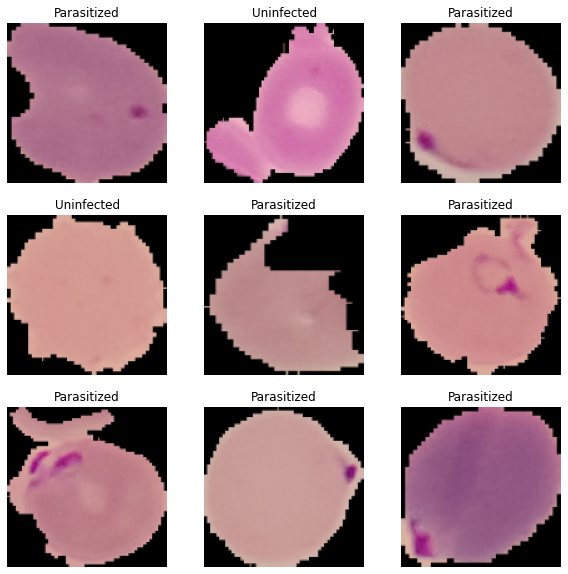

In [52]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Optymalizujemy budżet procesora dzięki funkcji AUTOTUNE

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Tworzymy pierwszy model złożony z sieci neuronowych

In [26]:
model0 = Sequential()
model0.add(tf.keras.layers.Flatten(input_shape=(img_height, img_width, 3)))
model0.add(Dense(64, activation='relu')) #liniowa funkcja aktywacji, umozliwia szybsze uczenie modelu
model0.add(Dense(32,  activation='relu'))
model0.add(Dense(1, activation='sigmoid'))
model0.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #wydajny obliczeniowo

W pierwszym modelu używamy sieci neuronowych wraz z funkcją aktywacji 'relu', ponieważ jest to liniowa funkcja aktywacji i umożliwia szybkie uczenie modelu oraz używamy optymalizatora 'adam', ponieważ jest wydajny obliczeniowo. Na końcu dodajemy neuron z funkcją aktywacji 'sigmoid', ponieważ rozróżniamy dwie klasy: Parasitized i Uninfected. Jako funkcję strat przyjmujemy 'binary_crossentropy', ponieważ rozróżniamy tylko dwie klasy.

Uczymy pierwszy model

In [27]:
m = model0.fit(
  train_ds,
  validation_data=val_ds,
  epochs=12
)

Epoch 1/12
276/276 [==============================] - 15s 50ms/step - loss: 162.1129 - accuracy: 0.5560 - val_loss: 36.1629 - val_accuracy: 0.6444
Epoch 2/12
276/276 [==============================] - 14s 51ms/step - loss: 76.9099 - accuracy: 0.5839 - val_loss: 26.5408 - val_accuracy: 0.6391
Epoch 3/12
276/276 [==============================] - 13s 48ms/step - loss: 60.4995 - accuracy: 0.5904 - val_loss: 16.3478 - val_accuracy: 0.6645
Epoch 4/12
276/276 [==============================] - 14s 51ms/step - loss: 38.6064 - accuracy: 0.6044 - val_loss: 21.3028 - val_accuracy: 0.5720
Epoch 5/12
276/276 [==============================] - 14s 52ms/step - loss: 23.9667 - accuracy: 0.6123 - val_loss: 17.7047 - val_accuracy: 0.5876
Epoch 6/12
276/276 [==============================] - 15s 53ms/step - loss: 17.1867 - accuracy: 0.5805 - val_loss: 0.9242 - val_accuracy: 0.6464
Epoch 7/12
276/276 [==============================] - 14s 51ms/step - loss: 1.0168 - accuracy: 0.6275 - val_loss: 0.6251 - v

Przedstawiamy wizualizacje nauki modelu w trakcie 12 epok z podziałem na zbiór treningowy i walidacyjny.

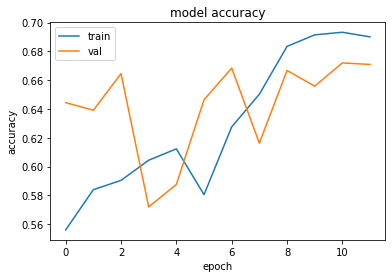

In [28]:
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Pierwszy model nauczył się na poziomie 67.2 %, co nie jest najlepszym wynikiem.

Tworzymy drugi model złożony z konwolucyjnych sieci neuronowych

In [58]:
model1 = tf.keras.Sequential()
model1.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model1.add(Conv2D(16, (8,8), activation='relu'))
model1.add(Conv2D(32, (4,4), activation='relu'))
model1.add(MaxPool2D(pool_size = (2,2), padding='valid'))
model1.add(Conv2D(64, (2,2), activation='relu'))
model1.add(Conv2D(128, (2,2), activation='relu'))
model1.add(MaxPool2D(pool_size = (2,2), padding='valid'))
model1.add(Flatten())
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer="adam", loss="binary_crossentropy",
              metrics=["accuracy"])
model1.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 121, 121, 16)      3088      
                                                                 
 conv2d_33 (Conv2D)          (None, 118, 118, 32)      8224      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 59, 59, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 58, 58, 64)        8256      
                                                                 
 conv2d_35 (Conv2D)          (None, 57, 57, 128)       32896     
                                                     

W drugim modelu używamy konwolucyjnych sieci neuronowych z funkcją aktywacji 'relu'. Najpierw zmieniamy rozmiar obrazu o podany współczynnik skalowania. Następnie dodajemy warstwy z ukrytymi neuronami oraz próbkujemy dane wzdłóż rozmiaru bez dopełnienia('MaxPool2D'). Na koniec dodajemy funkcję aktywacji 'sigmoid', optymalizator 'adam' oraz funkcję strat 'binary-crossentorpy'.

In [59]:
m = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
276/276 [==============================] - 847s 3s/step - loss: 0.6655 - accuracy: 0.5959 - val_loss: 0.6247 - val_accuracy: 0.6631
Epoch 2/10
276/276 [==============================] - 842s 3s/step - loss: 0.6368 - accuracy: 0.6449 - val_loss: 0.6862 - val_accuracy: 0.5427
Epoch 3/10
276/276 [==============================] - 848s 3s/step - loss: 0.6779 - accuracy: 0.5711 - val_loss: 0.6680 - val_accuracy: 0.6074
Epoch 4/10
276/276 [==============================] - 763s 3s/step - loss: 0.5941 - accuracy: 0.6901 - val_loss: 0.4320 - val_accuracy: 0.8003
Epoch 5/10
276/276 [==============================] - 697s 3s/step - loss: 0.6495 - accuracy: 0.6349 - val_loss: 0.6439 - val_accuracy: 0.6466
Epoch 6/10
276/276 [==============================] - 785s 3s/step - loss: 0.5289 - accuracy: 0.7252 - val_loss: 0.2240 - val_accuracy: 0.9314
Epoch 7/10
276/276 [==============================] - 669s 2s/step - loss: 0.1930 - accuracy: 0.9351 - val_loss: 0.1745 - val_accuracy: 0.9432

Przedstawiamy wizualizacje nauki modelu w trakcie 10 epok z podziałem na zbiór treningowy i walidacyjny.

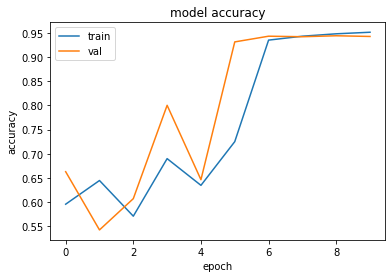

In [60]:
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Drugi model nauczył się na poziomie 94.4 %, co oznacza że konwolucyjna sieć neuronowa jest lepsza w rozróżnianiu zdjęć komórkowych niż zwykła sieć neuronowa.

Spróbujemy zmienić ilość warstw z ukrytymi neuronami oraz funkcję aktywacji i sprawdzimy czy model się poprawił.

Tworzymy trzeci model złożony z konwolucyjnych sieci neuronowych

In [61]:
model2 = tf.keras.Sequential()
model2.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model2.add(Conv2D(32, (8,8), activation='relu'))
model2.add(MaxPool2D(pool_size = (2,2), padding='valid'))
model2.add(Conv2D(64, (2,2), activation='softmax'))
model2.add(MaxPool2D(pool_size = (2,2), padding='valid'))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer="adam", loss="binary_crossentropy",
              metrics=["accuracy"])
model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 121, 121, 32)      6176      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 60, 60, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 59, 59, 64)        8256      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 29, 29, 64)       0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 53824)           

W drugim modelu używamy konwolucyjnych sieci neuronowych z funkcją aktywacji 'relu'. Najpierw zmieniamy rozmiar obrazu o podany współczynnik skalowania. Następnie dodajemy warstwy z ukrytymi neuronami, próbkujemy dane wzdłóż rozmiaru bez dopełnienia('MaxPool2D') oraz dodajemy funkcję aktywacji 'softmax'. Na koniec dodajemy funkcję aktywacji 'sigmoid', optymalizator 'adam' oraz funkcję strat 'binary-crossentorpy'.

Funkcja altywacji 'softmax' jest używana do klasyfikacji większej niż binarnej, jedakże zobaczmy jakie wyniki daje taki model.

In [62]:
m2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
276/276 [==============================] - 373s 1s/step - loss: 0.6799 - accuracy: 0.5581 - val_loss: 0.6388 - val_accuracy: 0.6348
Epoch 2/10
276/276 [==============================] - 383s 1s/step - loss: 0.6223 - accuracy: 0.6552 - val_loss: 0.6080 - val_accuracy: 0.6609
Epoch 3/10
276/276 [==============================] - 382s 1s/step - loss: 0.5884 - accuracy: 0.6950 - val_loss: 0.5537 - val_accuracy: 0.7083
Epoch 4/10
276/276 [==============================] - 425s 2s/step - loss: 0.4979 - accuracy: 0.7825 - val_loss: 0.4525 - val_accuracy: 0.7992
Epoch 5/10
276/276 [==============================] - 392s 1s/step - loss: 0.4088 - accuracy: 0.8450 - val_loss: 0.4160 - val_accuracy: 0.8121
Epoch 6/10
276/276 [==============================] - 415s 2s/step - loss: 0.3656 - accuracy: 0.8679 - val_loss: 0.3521 - val_accuracy: 0.8844
Epoch 7/10
276/276 [==============================] - 426s 2s/step - loss: 0.2991 - accuracy: 0.9031 - val_loss: 0.3041 - val_accuracy: 0.9002

Przedstawiamy wizualizacje nauki modelu w trakcie 10 epok z podziałem na zbiór treningowy i walidacyjny.

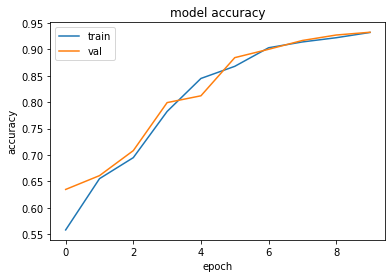

In [63]:
plt.plot(m2.history['accuracy'])
plt.plot(m2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Trzeci model nauczył się na poziomie 93.2 %, co oznacza że poprzedni model był lepszy i funkcja aktywacji 'softmax' nie poprawia wyniku.

Tworzymy czwarty model złożony z konwolucyjnych sieci neuronowych

In [24]:
model3 = Sequential()
model3.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model3.add(Conv2D(16, (3, 3), activation="relu"))
model3.add(MaxPool2D())
model3.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model3.add(MaxPool2D())
model3.add(Dropout(0.2))
model3.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model3.add(MaxPool2D())
model3.add(Flatten())
model3.add(Dropout(0.2))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(optimizer="adam", loss="binary_crossentropy",
              metrics=["accuracy"])

model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 63, 63, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 31, 31, 32)       

W czwartym modelu używamy konwolucyjnych sieci neuronowych z funkcją aktywacji 'relu'. Najpierw zmieniamy rozmiar obrazu o podany współczynnik skalowania. Następnie dodajemy warstwy z ukrytymi neuronami, próbkujemy dane wzdłóż rozmiaru z dopełnieniem ('MaxPool2D') oraz dodajemy funkcję 'Dropout', która ignoruje losowo wybrane 20 % neuronów podczas treningu. Na koniec dodajemy funkcję aktywacji 'sigmoid', optymalizator 'adam' oraz funkcję strat 'binary-crossentorpy'.

In [25]:
history = model3.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
276/276 [==============================] - 229s 825ms/step - loss: 0.5638 - accuracy: 0.6892 - val_loss: 0.2757 - val_accuracy: 0.8964
Epoch 2/5
276/276 [==============================] - 243s 880ms/step - loss: 0.2096 - accuracy: 0.9251 - val_loss: 0.1672 - val_accuracy: 0.9466
Epoch 3/5
276/276 [==============================] - 233s 844ms/step - loss: 0.1645 - accuracy: 0.9441 - val_loss: 0.1665 - val_accuracy: 0.9475
Epoch 4/5
276/276 [==============================] - 226s 818ms/step - loss: 0.1517 - accuracy: 0.9494 - val_loss: 0.1836 - val_accuracy: 0.9468
Epoch 5/5
276/276 [==============================] - 220s 798ms/step - loss: 0.1417 - accuracy: 0.9531 - val_loss: 0.1879 - val_accuracy: 0.9475


Przedstawiamy wizualizacje nauki modelu w trakcie 5 epok z podziałem na zbiór treningowy i walidacyjny.

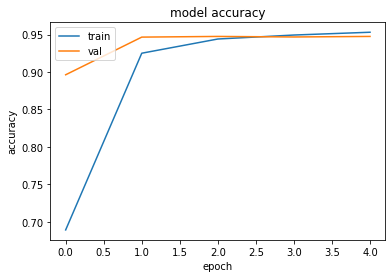

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Czwarty model nauczył się na poziomie 94.7 %, co oznacza że jest to model najlepszy z powyższych.

Predykcje na podstawie najlepszego modelu

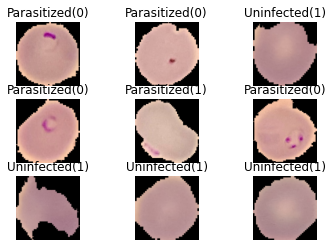

In [39]:
for images, labels in test_ds.take(2):
      for i in range(9):
            pred = model3.predict(images[i].numpy().reshape(1,img_width, img_height, 3))[0]
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]] + f'({int(np.round(pred))})')
            plt.axis("off")

Wnioski: Ostatni model dobrze przewidział 8 z 9 zdjęć komórkowych.